In [87]:
import json
import os
import random
import re
import skimage.io
import subprocess
import uuid

import cv2
import hdbscan
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw, ImageFilter
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap


In [88]:
metadata_fp = '/Users/erikstorrs/Documents/ding/cell-segmentation/data/box.json'
box_dir = '/Users/erikstorrs/Documents/ding/cell-segmentation/data/box/'

In [89]:
PADDING = 50

In [90]:
box_metadata = json.load(open(metadata_fp))
sample = 'F_1199_07'
roi = 'P005'
input_image = [x['filepath'] for x in box_metadata[sample][roi] if x['channel'] == 'dapi'][0]
output_dir = f'../outputs/{sample}_{roi}_cluster_trained'

In [65]:
# input_image = '/Users/erikstorrs/Documents/ding/cell-segmentation/data/dapi_NaKATPase_combined/F_1199_07_p000.png'
# output_dir = f'../outputs/p005_for_annotation'

## image processing

In [66]:
def chop_image(rgb_image, row_size=512, col_size=512, padding=50):
    padded_rgb = np.zeros((rgb_image.shape[0] + (padding * 2),
                          rgb_image.shape[1] + (padding * 2),
                          rgb_image.shape[2])).astype(np.uint8)
    padded_rgb[padding:rgb_image.shape[0] + padding,
              padding:rgb_image.shape[1] + padding,
              :] = rgb_image
    
    plt.imshow(padded_rgb)
    
    images = {}

    prev_r = padding
    prev_c = padding
    for i, r in enumerate(range(padding, rgb_image.shape[0] + padding + 1, row_size)):
        for j, c in enumerate(range(padding, rgb_image.shape[1] + padding + 1, col_size)):
            if r != padding and c != padding:
                images[(i, j)] = padded_rgb[prev_r - padding:r + padding, prev_c - padding:c + padding, :]
            prev_c = c
        prev_r = r
        
    return images

In [7]:
def process_image(image_fp, output_dir, segment_shape=(10, 10), rgb_start=False):
    image_id = f'{sample}_{roi}'
    
    # make output dir
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    if not os.path.isdir(os.path.join(output_dir, 'stage1_test')):
        os.mkdir(os.path.join(output_dir, 'stage1_test'))
    
    if not rgb_start:
        # convert to 3 channels
        gray_image = cv2.imread(image_fp, cv2.IMREAD_GRAYSCALE)
        rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    else:
        rgb_image = skimage.io.imread(image_fp)
        
    # calculate sizes
    row_size = int(rgb_image.shape[0] / segment_shape[0])
    col_size = int(rgb_image.shape[1] / segment_shape[1])
            
    # split up image
    location_to_image_chunks = chop_image(rgb_image, row_size=row_size, col_size=col_size,
                                         padding=PADDING)
        
    for (i, j), image_chunk in location_to_image_chunks.items():
        if not os.path.isdir(os.path.join(output_dir, 'stage1_test', f'{image_id}_{i}_{j}')):
            os.mkdir(os.path.join(output_dir, 'stage1_test', f'{image_id}_{i}_{j}'))
            os.mkdir(os.path.join(output_dir, 'stage1_test', f'{image_id}_{i}_{j}', 'images'))
            
        plt.imsave(os.path.join(output_dir, 'stage1_test', f'{image_id}_{i}_{j}', 'images', f'{image_id}_{i}_{j}.png'),
                   image_chunk)

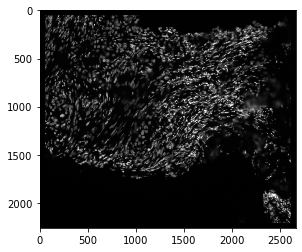

In [8]:
process_image(input_image, output_dir, rgb_start=False)
# process_image(input_image, output_dir, rgb_start=True, segment_shape=(8,8))

In [9]:
# import mgitools.os_helpers as os_helpers
# import shutil
# fps = os_helpers.listfiles(output_dir, regex=r'.png')
# for i, fp in enumerate(fps):
# #     file = fp.split('/')[-1]
#     shutil.copy(fp, f'/Users/erikstorrs/Documents/ding/cell-segmentation/data/dapi_NaKATPase_combined_processed/cell_segmentation_training_p000/{i}.png')
    

## nucleus segmentation

In [91]:
nucleus_script_fp = '/Users/erikstorrs/Documents/Mask_RCNN/samples/nucleus/nucleus.py'
# nucleus_script_fp = '/Users/erikstorrs/Documents/Mask_RCNN/samples/nucleus/cytoplasm.py'

weights_fp = '/Users/erikstorrs/Documents/Mask_RCNN/logs/nucleus20190522T1501/mask_rcnn_nucleus_0060.h5'
weights_fp = '/Users/erikstorrs/Documents/ding/cell_segmentation/models/mask_rcnn_nucleus_0040.h5'
weights_fp = '/Users/erikstorrs/Downloads/mask_rcnn_nucleus_0037.h5'
# weights_fp = '/Users/erikstorrs/Documents/Mask_RCNN/logs/cytoplasm/mask_rcnn_cytoplasm_0080.h5'
submission_dir = os.path.join(output_dir, 'submissions')

if not os.path.isdir(submission_dir):
    os.mkdir(submission_dir)

In [11]:
tool_args = (
    'python3', nucleus_script_fp, 'detect', '--dataset', output_dir, '--subset', 'stage1_test',
    '--weights', weights_fp, '--submission-dir', submission_dir
)

output = subprocess.check_output(tool_args)

## world building

In [130]:
def get_widht_height_normalized_cells(slide_segments):
    cells = []
    
    height = len(slide_segments) * slide_segments[0][0].height
    width = len(slide_segments[0]) * slide_segments[0][0].width
        
    for r in range(len(slide_segments)):
        for c in range(len(slide_segments[0])):
            segment = slide_segments[r][c]
            
            for cell in segment.cells:

                
#                 # adjust mask for padding
#                 cell.nucleus_mask = cell.nucleus_mask[PADDING:cell.nucleus_mask.shape[0] - PADDING, PADDING:cell.nucleus_mask.shape[1] - PADDING]
#                 # adjust bounding box for padding
#                 cell.nucleus_bbox = [x - PADDING for x in cell.nucleus_bbox]

                new_cx = (c * segment.width) + cell.cx
                new_cy = (r * segment.height) + cell.cy
                
                new_bbox = [
                    (r * segment.height) + cell.nucleus_bbox[0],
                    (c * segment.width) + cell.nucleus_bbox[1],
                    (r * segment.height) + cell.nucleus_bbox[2],
                    (c * segment.width) + cell.nucleus_bbox[3]
                ]

                new_mask = np.zeros((height, width)).astype(bool)

                new_y1 = max((r * segment.height) - PADDING, 0)
                new_y2 = min(((r + 1) * segment.height) + PADDING, height)
                new_x1 = max((c * segment.width) - PADDING, 0)
                new_x2 = min(((c + 1) * segment.width) + PADDING, width)
                
                old_y1, old_y2, old_x1, old_x2 = (0, cell.unshaped_nucleus_mask.shape[0], 
                                                  0, cell.unshaped_nucleus_mask.shape[1])
                if r == 0:
                    old_y1 = PADDING
                if r == len(slide_segments) - 1:
                    old_y2 = cell.unshaped_nucleus_mask.shape[0] - PADDING
                if c == 0:
                    old_x1 = PADDING
                if c == len(slide_segments[0]) - 1:
                    old_x2 = cell.unshaped_nucleus_mask.shape[1] - PADDING
                
#                 print(y1, y2, x1, x2)
#                 print(segment.height, segment.width)
#                 print(cell.unshaped_nucleus_mask.shape)
                new_mask[new_y1:new_y2, new_x1:new_x2] = cell.unshaped_nucleus_mask[old_y1:old_y2, old_x1:old_x2]
                
#                 new_mask[new_y1:new_y2, new_x1:new_x2] = cell.unshaped_nucleus_mask
                
                new_cell = Cell(cell.id, cell.nucleus_confidence, new_bbox, new_mask)
                cells.append(new_cell)
                
    return width, height, cells
            
            

In [116]:
class Slide(object):
    def __init__(self, slide_id, slide_segments):
        self.id = slide_id
        self.slide_segments = slide_segments
    
        self.width, self.height, self.cells = get_widht_height_normalized_cells(slide_segments)
        
class SlideSegment(object):
    def __init__(self, segment_id, height, width, cells, x, y):
        self.id = segment_id
        self.width = width
        self.height = height
        self.cells = cells
        
        self.x = x
        self.y = y

class Cell(object):
    def __init__(self, cell_id, nucleus_confidence, nucleus_bbox, nucleus_mask):
        self.id = cell_id
        self.nucleus_bbox = nucleus_bbox
        self.nucleus_mask = nucleus_mask
        self.unshaped_nucleus_mask = None
        self.nucleus_confidence = nucleus_confidence
        
        self.cell_mask = None
        self.cell_polygon = None
        
        self.cx = int(nucleus_bbox[1] + (np.abs(nucleus_bbox[1] - nucleus_bbox[3]) / 2))
        self.cy = int(nucleus_bbox[0] + (np.abs(nucleus_bbox[0] - nucleus_bbox[2]) / 2))
        
        self.channel_intensity_dict = None
        
    def get_nucleus_radius(self):
        return max(np.abs(self.nucleus_bbox[0] - self.nucleus_bbox[2]) / 2,
                   np.abs(self.nucleus_bbox[1] - self.nucleus_bbox[3]) / 2)
    
    def get_nucleus_area(self):
        return np.sum(self.nucleus_mask)
    
    def get_cell_area(self):
        return np.sum(self.cell_mask)

In [117]:
segment_id_to_data = {fp.split('.')[0]:json.load(open(os.path.join(submission_dir, fp)))
        for fp in os.listdir(submission_dir)
        if 'submit' not in fp
        if '.json' in fp}

In [118]:
row_size = max([int(re.sub(r'^.*([0-9]+)_[0-9]+$', r'\1', s))
                for s in segment_id_to_data.keys()])
col_size = max([int(re.sub(r'^.*[0-9]+_([0-9]+)$', r'\1', s))
                for s in segment_id_to_data.keys()])

# cell_mask_width = 

# cell.nucleus_mask[PADDING:cell.nucleus_mask.shape[0] - PADDING, PADDING:cell.nucleus_mask.shape[1] - PADDING]

slide_segments = np.zeros((row_size, col_size)).tolist()
for slide_segment_id, data in segment_id_to_data.items():
    cells = []
    for confidence, mask, bbox in zip(data['scores'], data['masks'], data['rois']):
        cell_id = str(uuid.uuid4())
        
        mask = np.asarray(mask)        
        
        cell = Cell(cell_id, confidence, bbox, mask)
        
        # make sure cell isn't in padded region
        if cell.cx >= 50 and cell.cx <= cell.nucleus_mask.shape[1] - PADDING and cell.cy >= 50 and cell.cy <= cell.nucleus_mask.shape[0] - PADDING:
                # save original mask for later
                cell.unshaped_nucleus_mask = np.copy(cell.nucleus_mask)
                # adjust mask for padding
                cell.nucleus_mask = cell.nucleus_mask[PADDING:cell.nucleus_mask.shape[0] - PADDING, PADDING:cell.nucleus_mask.shape[1] - PADDING]
                # adjust bounding box for padding
                cell.nucleus_bbox = [x - PADDING for x in cell.nucleus_bbox]
                cells.append(cell)
    
    r = int(re.sub(r'^.*([0-9]+)_[0-9]+$', r'\1', slide_segment_id)) - 1
    c = int(re.sub(r'^.*[0-9]+_([0-9]+)$', r'\1', slide_segment_id)) - 1
    
    if cells:
        segment = SlideSegment(slide_segment_id,
                               cells[0].nucleus_mask.shape[0], cells[0].nucleus_mask.shape[1], cells, r, c)
    else:
        segment = SlideSegment(slide_segment_id, 0, 0, [], r, c)
    slide_segments[r][c] = segment
    
    

In [131]:
slide = Slide(f'{sample}_{roi}', slide_segments)

add cytoplasm mask

In [97]:
# def add_cytoplasm_masks(slide):
#     pts = [(c.cx, c.cy) for c in slide.cells]
#     vor = Voronoi(pts)
#     for i, region_i in enumerate(vor.point_region):
#         if region_i != -1:
#             cell = slide.cells[i]
#             region = vor.regions[region_i]
#             vertices = [vor.vertices[x] for x in region]

#             polygon = [(int(x), int(y)) for x, y in vertices]

#             img = Image.new('L', (slide.width, slide.height), 0)
#             ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
#             mask = np.array(img).astype(bool)

#             cell.cell_mask = mask
#             cell.cell_polygon = polygon

# def shrink_cells(cells, cell_area_threshold, n_pixels=3):
#     for i, cell in enumerate(cells):
#         if i % 500 == 0:
#             print(i)
            
#         if cell.get_cell_area() > cell_area_threshold:
#             # expand cell mask by 3 pixels
#             xs = [x for x, y in cell.cell_polygon]
#             ys = [y for x, y in cell.cell_polygon]
#             bbox = [min(ys), min(xs), max(ys), max(xs)]
            
#             cell.cell_mask = expand_mask(cell.nucleus_mask, n_pixels, bbox)
def expand_mask(mask, n_pixels, bbox):
    new_mask = np.copy(mask)
    padded_bbox = [
                    max(bbox[0] - (n_pixels * 2), 0),
                    max(bbox[1] - (n_pixels * 2), 0),
                    min(bbox[2] + (n_pixels * 2), new_mask.shape[0]),
                    min(bbox[3] + (n_pixels * 2), new_mask.shape[1])
                   ]
    new = [True] * n_pixels
    new = np.asarray(new).reshape(1, n_pixels)
    
    for r in range(padded_bbox[0], padded_bbox[2]):

        prev = False
        for c in range(padded_bbox[1], padded_bbox[3]):
            if new_mask[r, c] and prev == False:
                stop = max(c - n_pixels, 0)
                new = [True] * (c - stop)
                new = np.asarray(new).reshape(1, (c - stop))
                new_mask[r:r+1, stop:c] = new
            elif not new_mask[r, c] and prev == True:
                stop = min(c + n_pixels, new_mask.shape[1])
                new = [True] * (stop - c)
                new = np.asarray(new).reshape(1, (stop - c))
                new_mask[r:r+1, c:stop] = new
                break
            prev = new_mask[r, c]
            
                
    new = [True] * n_pixels
    new = np.asarray(new).reshape(n_pixels, 1)
           
    for c in range(padded_bbox[1], padded_bbox[3]):
        prev = False
        for r in range(padded_bbox[0], padded_bbox[2]):
            if new_mask[r, c] and prev == False:
                stop = max(r - n_pixels, 0)
                new = [True] * (r - stop)
                new = np.asarray(new).reshape((r - stop), 1)
                new_mask[stop:r, c:c+1] = new
            elif not new_mask[r, c] and prev == True:
                stop = min(r + n_pixels, new_mask.shape[0])
                new = [True] * (stop - r)
                new = np.asarray(new).reshape((stop - r), 1)
                new_mask[r:stop, c:c+1] = new
                break
            prev = new_mask[r, c]
                
    return new_mask

def add_cytoplasm_masks(slide, n_pixels=3):
    for cell in slide.cells:
#         bbox = [max(cell.nucleus_bbox[0] - 5, 0),
#                 max(cell.nucleus_bbox[1] - 5, 0),
#                 min(cell.nucleus_bbox[2] + 5, slide.height),
#                 min(cell.nucleus_bbox[3] + 5, slide.width)]
        cell.cell_mask = expand_mask(cell.nucleus_mask, n_pixels, cell.nucleus_bbox)
        
        
    
#     pts = [(c.cx, c.cy) for c in slide.cells]
#     vor = Voronoi(pts)
#     for i, region_i in enumerate(vor.point_region):
#         if region_i != -1:
#             cell = slide.cells[i]
#             region = vor.regions[region_i]
#             vertices = [vor.vertices[x] for x in region]

#             polygon = [(int(x), int(y)) for x, y in vertices]

#             img = Image.new('L', (slide.width, slide.height), 0)
#             ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
#             mask = np.array(img).astype(bool)

#             cell.cell_mask = mask
#             cell.cell_polygon = polygon

In [138]:
add_cytoplasm_masks(slide, n_pixels=1)

In [139]:
slide.cells[0].get_nucleus_area(), slide.cells[0].get_cell_area()

(412, 498)

## cell area distribution

In [140]:
cell_areas = [c.get_cell_area() for c in slide.cells]

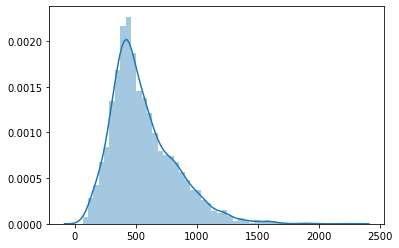

In [141]:
sns.distplot([a for a in cell_areas if a < 10000], hist=True)
# plt.xlim((0, 1000000))

In [142]:
nucleus_radiuses = [c.get_nucleus_radius() for c in slide.cells]

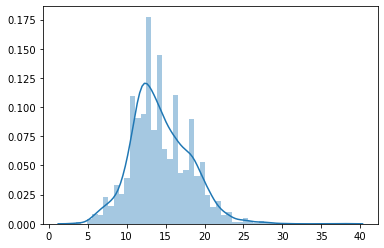

In [143]:
sns.distplot([a for a in nucleus_radiuses if a < 10000], hist=True)


In [144]:
cell_radiuses = [np.sqrt((c.get_cell_area() / 6.28)) for c in slide.cells]

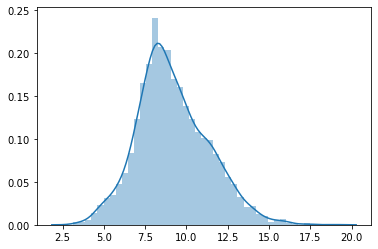

In [145]:
sns.distplot([a for a in cell_radiuses if a < 40], hist=True)


In [146]:
colors = [(255, 150, 150), (255, 0, 150), (255, 150, 0), (255, 255, 0), (255, 150, 255), (255, 0, 255),
         (255, 0, 0), (0, 150, 150), (0, 255, 150), (0, 255, 0), (0, 0, 255)]

In [147]:
# images = [np.array(Image.new('RGB', (slide.cells[0].cell_mask.shape[1],slide.cells[0].cell_mask.shape[0]) , c))
#           for c in colors]

images = [np.array(Image.new('RGB', (slide.cells[0].nucleus_mask.shape[1],slide.cells[0].nucleus_mask.shape[0]) , c))
          for c in colors]

In [148]:
# def expand_mask(mask, n_pixels, bbox):
#     new_mask = np.copy(mask)
#     padded_bbox = [
#                     max(bbox[0] - (n_pixels * 2), 0),
#                     max(bbox[1] - (n_pixels * 2), 0),
#                     min(bbox[2] + (n_pixels * 2), new_mask.shape[0]),
#                     min(bbox[3] + (n_pixels * 2), new_mask.shape[1])
#                    ]
#     new = [True] * n_pixels
#     new = np.asarray(new).reshape(1, n_pixels)
    
#     for r in range(padded_bbox[0], padded_bbox[2]):

#         prev = False
#         for c in range(padded_bbox[1], padded_bbox[3]):
#             if new_mask[r, c] and prev == False:
#                 stop = max(c - n_pixels, 0)
#                 new = [True] * (c - stop)
#                 new = np.asarray(new).reshape(1, (c - stop))
#                 new_mask[r:r+1, stop:c] = new
#             elif not new_mask[r, c] and prev == True:
#                 stop = min(c + n_pixels, new_mask.shape[1])
#                 new = [True] * (stop - c)
#                 new = np.asarray(new).reshape(1, (stop - c))
#                 new_mask[r:r+1, c:stop] = new
#                 break
#             prev = new_mask[r, c]
            
                
#     new = [True] * n_pixels
#     new = np.asarray(new).reshape(n_pixels, 1)
           
#     for c in range(padded_bbox[1], padded_bbox[3]):
#         prev = False
#         for r in range(padded_bbox[0], padded_bbox[2]):
#             if new_mask[r, c] and prev == False:
#                 stop = max(r - n_pixels, 0)
#                 new = [True] * (r - stop)
#                 new = np.asarray(new).reshape((r - stop), 1)
#                 new_mask[stop:r, c:c+1] = new
#             elif not new_mask[r, c] and prev == True:
#                 stop = min(r + n_pixels, new_mask.shape[0])
#                 new = [True] * (stop - r)
#                 new = np.asarray(new).reshape((stop - r), 1)
#                 new_mask[r:stop, c:c+1] = new
#                 break
#             prev = new_mask[r, c]
                
#     return new_mask
                

In [149]:
# def shrink_cells(cells, cell_area_threshold, n_pixels=3):
#     for i, cell in enumerate(cells):
#         if i % 500 == 0:
#             print(i)
            
#         if cell.get_cell_area() > cell_area_threshold:
#             # expand cell mask by 3 pixels
#             xs = [x for x, y in cell.cell_polygon]
#             ys = [y for x, y in cell.cell_polygon]
#             bbox = [min(ys), min(xs), max(ys), max(xs)]
            
#             cell.cell_mask = expand_mask(cell.nucleus_mask, n_pixels, bbox)

In [150]:
# shrink_cells(slide.cells, 2200)

In [151]:
output_figures_dir = os.path.join(output_dir, 'figures')

if not os.path.isdir(output_figures_dir):
    os.mkdir(output_figures_dir)

0
500
1000
1500
2000
2500
3000
3500


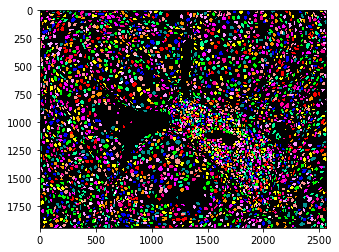

In [152]:
image = np.zeros((slide.cells[0].nucleus_mask.shape[0], slide.cells[0].nucleus_mask.shape[1], 3), np.uint8)
for i, cell in enumerate(slide.cells):
    if i % 500 == 0:
        print(i)
        
    index = random.randint(0, len(images) - 1)
    img = images[index]
    colored_mask = cv2.bitwise_and(img, img, mask=cell.nucleus_mask.astype(np.uint8))

    image = cv2.add(image, colored_mask)
plt.imshow(image)
plt.savefig(os.path.join(output_figures_dir, 'all_nuclei.png'), dpi=800)

In [153]:
image = np.zeros((slide.cells[0].cell_mask.shape[0], slide.cells[0].cell_mask.shape[1], 3), np.uint8)
for i, cell in enumerate(slide.cells):
    if i % 500 == 0:
        print(i)
        
    index = random.randint(0, len(images) - 1)
    img = images[index]
    colored_mask = cv2.bitwise_and(img, img, mask=cell.cell_mask.astype(np.uint8))

    image = cv2.add(image, colored_mask)

0
500
1000
1500
2000
2500
3000
3500


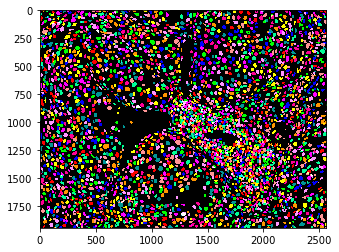

In [154]:
plt.imshow(image)
plt.savefig(os.path.join(output_figures_dir, 'all_cells.png'), dpi=800)

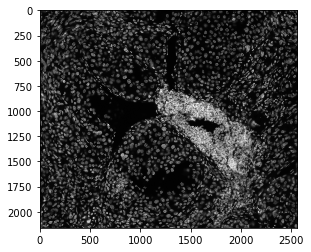

In [155]:
image = cv2.imread(input_image, cv2.IMREAD_COLOR)
plt.imshow(image)
plt.savefig(os.path.join(output_figures_dir, 'original_dapi.png'), dpi=1000)

### apply channels

In [156]:
channel_metadatas = [d for d in box_metadata[sample][roi] if d['channel'] not in ['dapi', 'NaKATPase']]
channel_to_image = {}
for metadata in channel_metadatas:
    fp = metadata['filepath']
    channel = metadata['channel']
    
    gray_image = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    gray_image = gray_image[:slide.height, :slide.width]
    channel_to_image[channel] = gray_image

channel_to_image.keys()

dict_keys(['Ki67', 'CD3', 'CD20', 'PDL1', 'CD56', 'CD8', 'PD1', 'SOX10', 'CD68', 'CD45', 'FOXP3', 'CD4'])

In [157]:
# channel_dir = '../data/channels/'

In [158]:
# channel_to_image = {}
# for fp in os.listdir(channel_dir):
#     cy_channel = fp.split('.')[-2][-3:]
    
#     cy3 = re.sub(r'^.*Dapi_dapi_(.*)_cy3_.*$', r'\1', fp.split('/')[-1])
#     cy5 = re.sub(r'^.*Dapi_dapi.*_([^_]*)_cy5_.*$', r'\1', fp.split('/')[-1])
    
#     if cy_channel == 'cy3':
#         channel = cy3
#     elif cy_channel == 'cy5':
#         channel = cy5
        
        
#     gray_image = cv2.imread(os.path.join(channel_dir, fp), cv2.IMREAD_GRAYSCALE)
# #     rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
#     gray_image = gray_image[:slide.height, :slide.width]
    
#     channel_to_image[channel] = gray_image
    
# channel_to_image.keys()

add intensities to cells

In [159]:
for i, cell in enumerate(slide.cells):
    if i % 500 == 0:
        print(i)
        
    for channel, image in channel_to_image.items():
        m = cv2.bitwise_and(image, image, mask=cell.cell_mask.astype(np.uint8))
        
        if cell.channel_intensity_dict is None:
            cell.channel_intensity_dict = {channel: np.sum(m) / cell.get_cell_area()}
        else:
            cell.channel_intensity_dict[channel] = np.sum(m) / cell.get_cell_area()

0
500
1000
1500
2000
2500
3000
3500


### make tabular

In [160]:
d = {channel:[] for channel in channel_to_image.keys()}

for cell in slide.cells:
    for channel, intensity in cell.channel_intensity_dict.items():
        d[channel].append(intensity)
        
df = pd.DataFrame.from_dict(d)
df.index = [c.id for c in slide.cells]

In [161]:
df.head(5)

,Ki67,CD3,CD20,PDL1,CD56,CD8,PD1,SOX10,CD68,CD45,FOXP3,CD4
0d3afcc6-02c9-46e6-844a-3c9bcf314d3f,0.226908,2.423695,5.783133,5.736948,15.311245,2.076305,1.945783,11.887550,9.413655,6.463855,2.092369,11.771084
7119438b-d768-4296-b5c3-796da4d22d9c,0.275685,2.296233,5.352740,6.183219,15.943493,1.924658,1.710616,10.315068,9.770548,5.981164,2.250000,11.895548
4eb4c073-fe17-4c71-9934-c33df4c8eaa2,0.926421,4.479933,7.974916,8.127090,16.311037,4.005017,4.172241,14.209030,38.311037,11.488294,3.627090,18.183946
cc2f5ef8-fb19-4327-9e4e-aec544bbf0a9,0.166667,2.366876,4.623690,5.365828,13.203354,1.868973,1.876310,10.688679,9.036688,5.093291,2.489518,10.621593
bf55ca24-e41b-4a53-b292-a83a50268786,0.084656,1.617284,3.917108,4.564374,12.312169,1.409171,1.379189,7.499118,6.465608,5.945326,1.462081,9.564374


In [162]:
df.to_csv(os.path.join(output_figures_dir, 'cell_intensities.tsv'), sep='\t')

### do umap

In [163]:
X = df.values

In [164]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [165]:
# X_embedded = TSNE(n_components=2).fit_transform(X)
# X_embedded.shape

X_embedded = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X)

In [166]:
labels = hdbscan.HDBSCAN(
    min_samples=50,
    min_cluster_size=50,
).fit_predict(X_embedded)

In [167]:
plotting_df = pd.DataFrame(data=X_embedded, columns=['TSNE1', 'TSNE2'], index=df.index)
for c in df.columns:
    plotting_df[c] = list(df[c])
plotting_df['cluster'] = labels

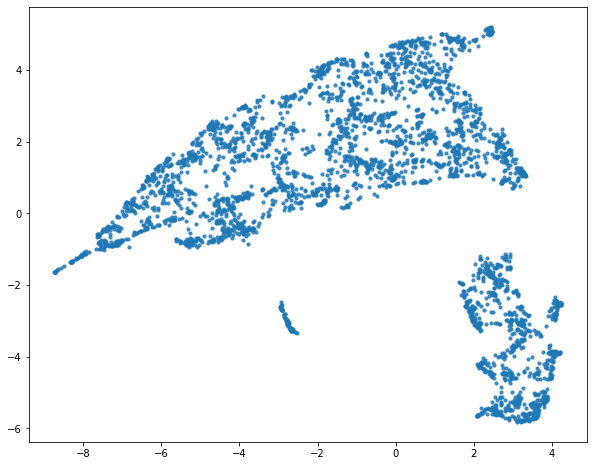

In [168]:
plt.figure(figsize=(10,8))
plt.scatter(plotting_df.TSNE1, plotting_df.TSNE2, alpha = .8, s=10)

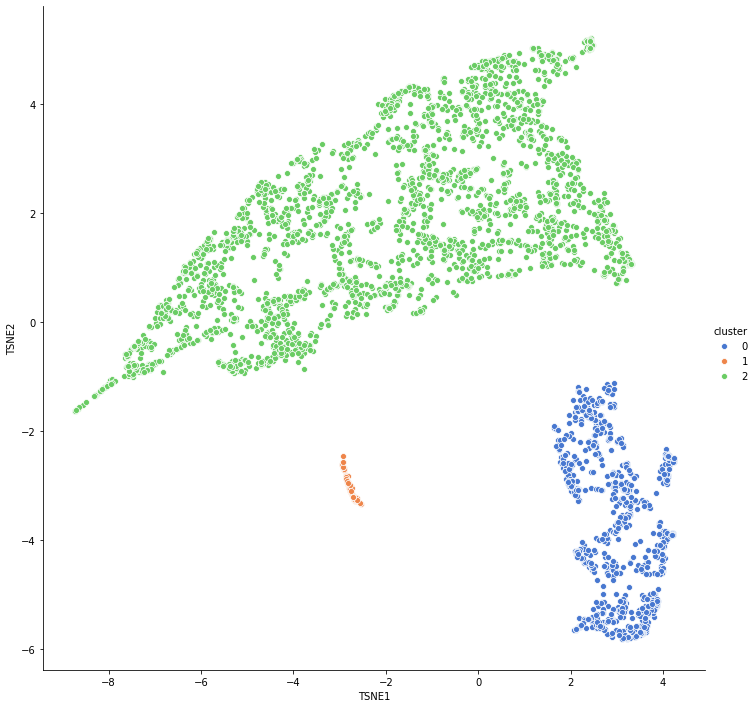

In [169]:
axs = sns.pairplot(plotting_df, x_vars=['TSNE1'], y_vars=['TSNE2'], hue='cluster', height=10,
                  palette='muted')
plt.savefig(os.path.join(output_figures_dir, 'clustered_cells.png'), dpi=1000)

In [170]:
# current_palette = sns.color_palette(palette='muted')


In [171]:
# current_palette.as_hex()

CD20
CD3
CD4
CD45
CD56
CD68
CD8
FOXP3
Ki67
PD1
PDL1
SOX10


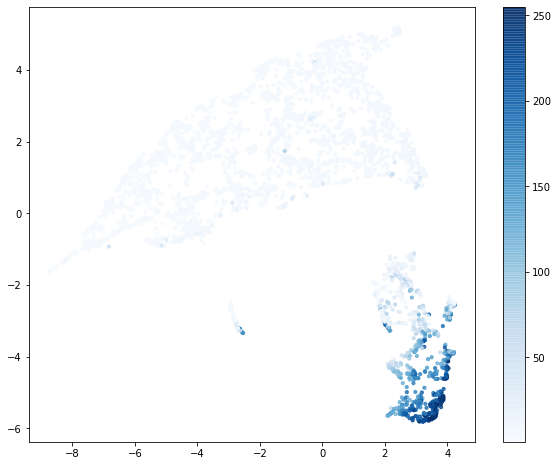

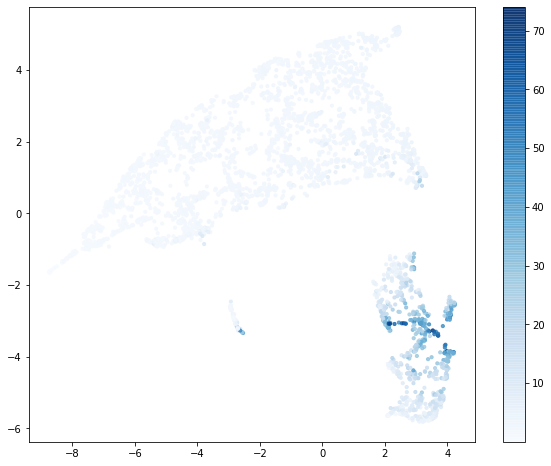

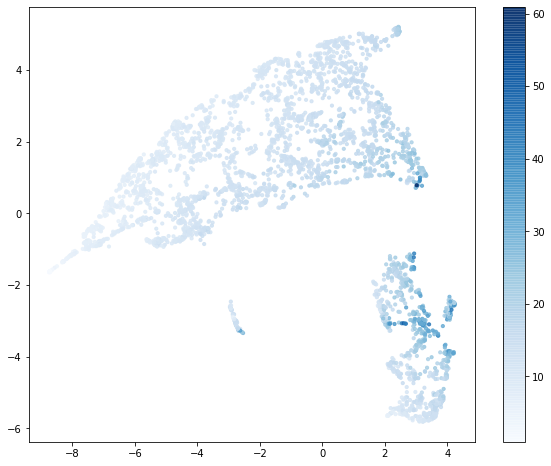

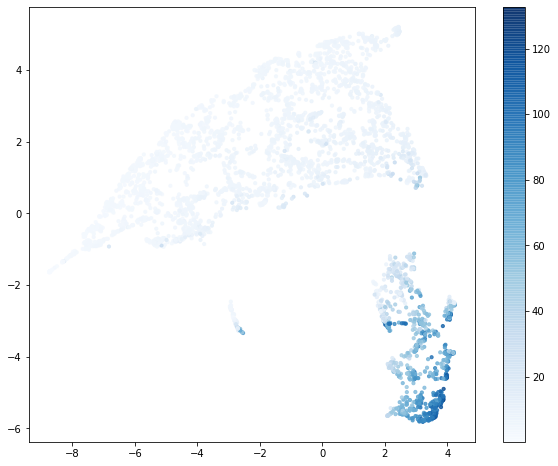

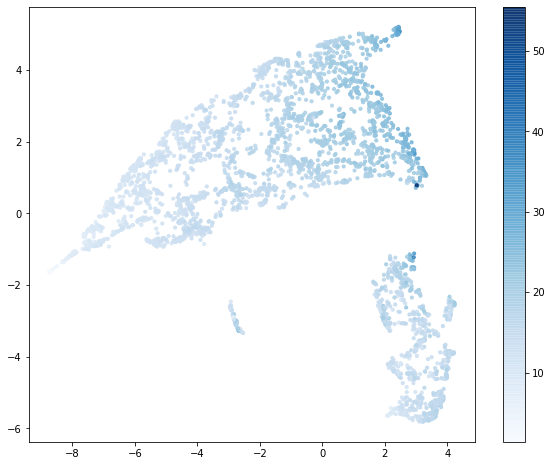

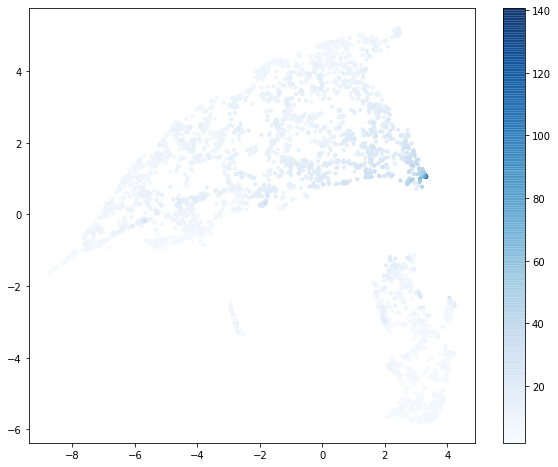

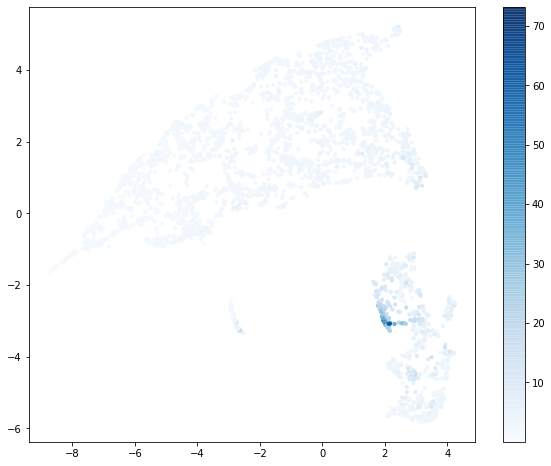

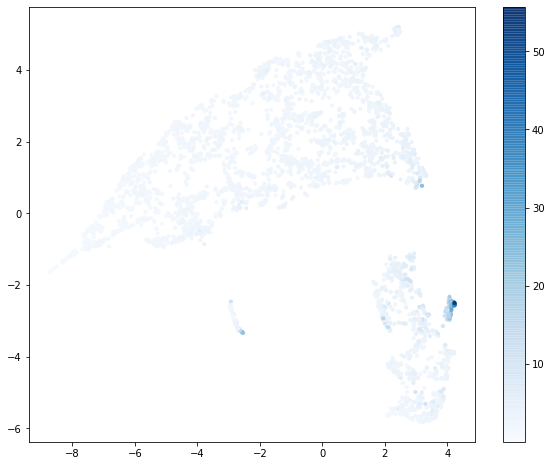

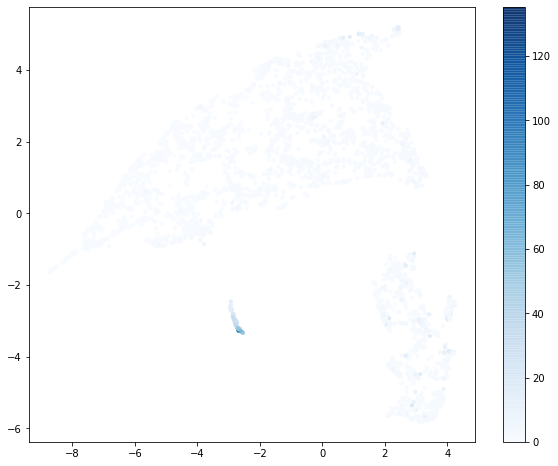

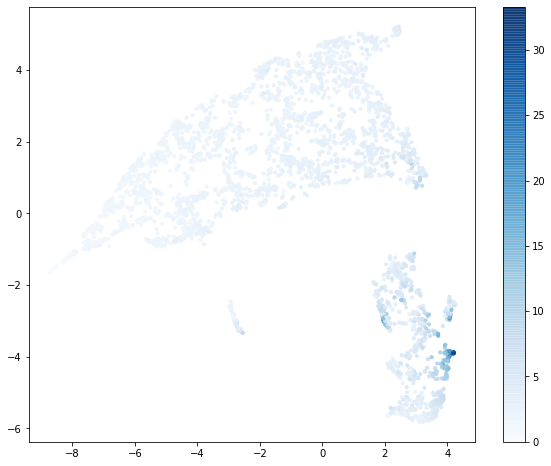

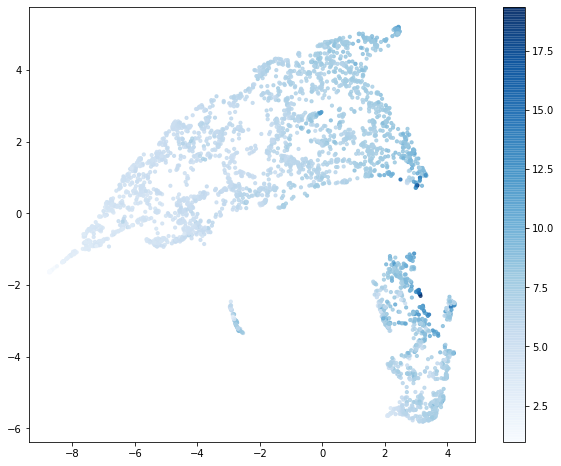

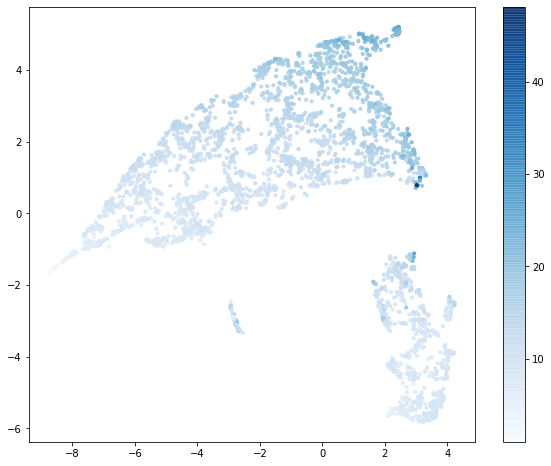

In [172]:
for c in sorted(df.columns):
    print(c)
    plt.figure(figsize=(10,8))
    plt.scatter(plotting_df.TSNE1, plotting_df.TSNE2, alpha=.8, c=plotting_df[c],  cmap='Blues', s=10)
    cbar = plt.colorbar()
#     plt.show()
    plt.savefig(os.path.join(output_figures_dir, f'heatmap_{c}.png'), dpi=300)
    

## map back to slide image

In [173]:
cell_id_to_cells = {cell.id:cell for cell in slide.cells}

In [174]:
images = [np.array(Image.new('RGB', (slide.cells[0].cell_mask.shape[1],slide.cells[0].cell_mask.shape[0]) , c))
          for c in sns.color_palette(palette='muted').as_hex()]

In [175]:
id_to_cluster = {i:row['cluster'] for i, row in plotting_df.iterrows()}

In [176]:
image = np.zeros((slide.cells[0].cell_mask.shape[0], slide.cells[0].cell_mask.shape[1],3), np.uint8)

for cell in slide.cells:
    if cell.id in id_to_cluster:
        img = images[int(id_to_cluster[cell.id]) + 1]
        colored_mask = cv2.bitwise_and(img, img, mask=cell.cell_mask.astype(np.uint8))

        image = cv2.add(image, colored_mask)

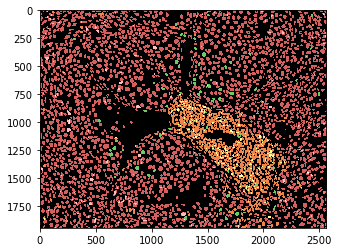

In [177]:
plt.imshow(image)
plt.savefig(os.path.join(output_figures_dir, 'clusters_mapped_back.png'), dpi=1000)

## write slide to file

In [178]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [179]:
def slide_to_json(slide):
    slide_json = {
        'id': slide.id,
        'cells': [],
        'width': slide.width,
        'height': slide.height
    }
    
    for i, cell in enumerate(slide.cells):
        if i % 500 == 0:
            print(i)
            
        encoded_nucleus = rle_encode(cell.nucleus_mask.astype(int))
        encoded_cell = rle_encode(cell.cell_mask.astype(int))
        
        cell_data = {
            'id': cell.id,
            'nucleus_mask': encoded_nucleus,
            'cell_mask': encoded_cell,
            'channel_intensities': {c:round(i, 2) for c, i in cell.channel_intensity_dict.items()}
        }
        
        slide_json['cells'].append(cell_data)
        
    return slide_json

In [180]:
slide_json = slide_to_json(slide)

0
500
1000
1500
2000
2500
3000
3500


In [181]:
json.dump(slide_json, open(os.path.join(output_figures_dir, 'slide.json'), 'w'))